In [4]:
"""
Created on 26.09.2023
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4


def create_X(x, y, n):
    """Returns the design matrix X from coordinates x and y with n polynomial degrees."""
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int(i * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x**(i - k)) * (y**k)

    return X


def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)


def R2_score(y_actual, y_model):
    """Returns the R2 score of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return 1 - np.sum((y_actual - y_model)**2) / np.sum((y_actual - np.mean(y_actual))**2)


def MSE_Ridge_beta_R2(X_train, X_test, y_train, y_test, lamb):
    """Performs Ridge regression and returns the MSE, R2, and beta values for each lambda value in lamb."""
    mse_test = np.zeros(len(lamb))
    mse_train = np.zeros(len(lamb))
    r2_train = np.zeros(len(lamb))
    r2_test = np.zeros(len(lamb))
    beta = []

    I = np.identity(X_train.shape[1])
    for i in range(len(lamb)):
        # Make ridge regression
        beta_rid = np.linalg.pinv(X_train.T @ X_train + lamb[i] * I) @ X_train.T @ y_train

        # Make prediction
        y_tilde = X_train @ beta_rid
        y_predict = X_test @ beta_rid

        # Compute MSE, beta and R2 values
        mse_train[i] = MSE(y_train, y_tilde)
        mse_test[i] = MSE(y_test, y_predict)
        beta.append(beta_rid)
        r2_train[i] = R2_score(y_train, y_tilde)
        r2_test[i] = R2_score(y_test, y_predict)
    return mse_train, mse_test, beta, r2_train, r2_test


# PARAMETERS
n = 1000  # number of data points
maxdegree = 6  # max polynomial degree for plotting
lmbda_vals = np.linspace(0.0001, 1, 50)
noise_std = 1

# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()

# Create data set
np.random.seed(2023)
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))

# Get franke function with noise
noise = np.random.normal(0, noise_std, x.shape)
z = FrankeFunction(x, y) + noise
scaler = StandardScaler()

# Make lists which will contain plot data
degrees = np.arange(0, maxdegree, 1)
mse_train_arr = []
mse_test_arr = []
beta_arr = []
r2_train_arr = []
r2_test_arr = []

# Iterate through all the different polynomial degrees
for degree in degrees:
    # Create design matrix X
    X = create_X(x, y, n=degree)  # intercept included

    # Split in training and test data
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform ridge regression
    mse_train, mse_test, beta, r2_train, r2_test = MSE_Ridge_beta_R2(
            X_train_scaled, X_test_scaled, z_train, z_test, lmbda_vals)
    mse_train_arr.append(mse_train)
    mse_test_arr.append(mse_test)
    beta_arr.append(beta)
    r2_train_arr.append(r2_train)
    r2_test_arr.append(r2_test)

In [5]:
X.shape

(1000, 21)

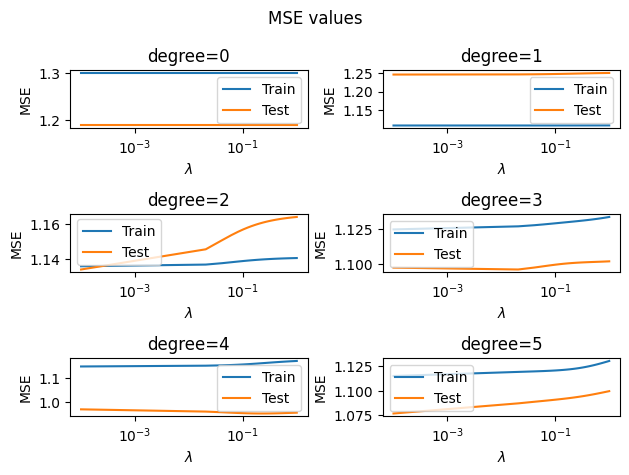

In [6]:
# Plot MSE's
figsize = (8, 5)
fig = plt.figure()
fig.suptitle("MSE values")
for degree in degrees:
    plt.subplot(3, 2, degree + 1)
    plt.title(f"{degree=}")
    plt.plot(lmbda_vals, mse_train_arr[degree], label=f"Train")
    plt.plot(lmbda_vals, mse_test_arr[degree], label=f"Test")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE")
    plt.xscale("log")
plt.tight_layout()

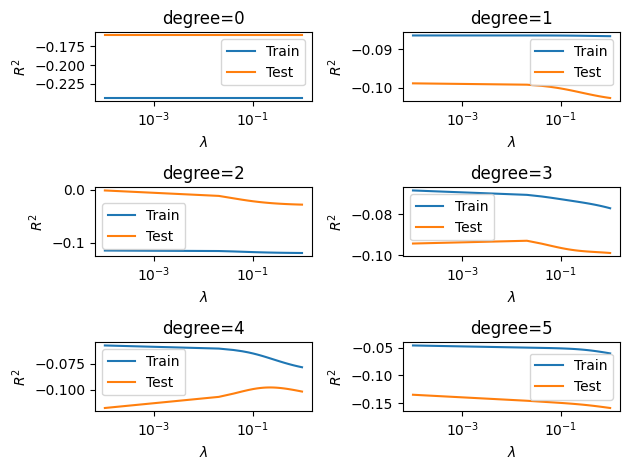

In [7]:
# Plot R2's
# fig = plt.figure(figsize=figsize)
fig.suptitle("R2 scores")
for degree in degrees:
    plt.subplot(3, 2, degree + 1)
    plt.title(f"{degree=}")
    plt.plot(lmbda_vals, r2_train_arr[degree], label=f"Train")
    plt.plot(lmbda_vals, r2_test_arr[degree], label=f"Test")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("$R^2$")
    plt.xscale("log")
plt.tight_layout()

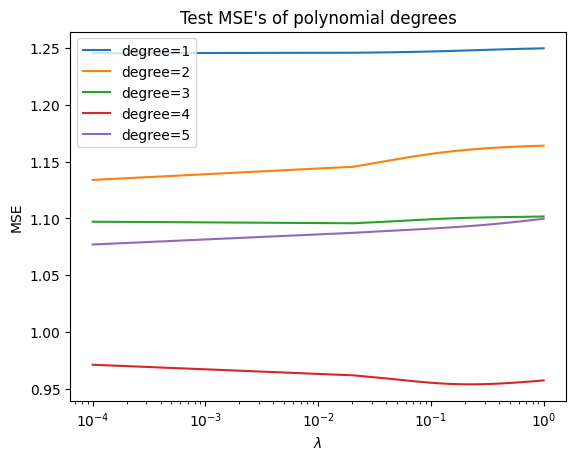

In [8]:
# Plot test MSE's in same figure
# plt.figure(figsize=figsize)
plt.title("Test MSE's of polynomial degrees")
for degree in degrees[1:]:
    plt.plot(lmbda_vals, mse_test_arr[degree], label=f"{degree=}")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE")
    plt.xscale("log")
plt.savefig(FIGURES_DIR / "part_b_MSE.png")

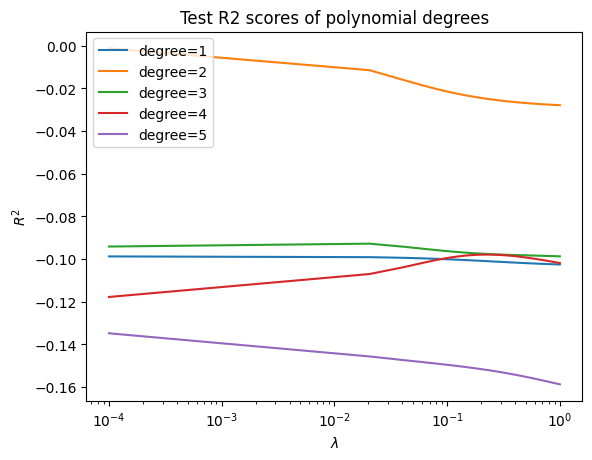

In [9]:
# Plot test R2's in same figure
# plt.figure(figsize=figsize)
plt.title("Test R2 scores of polynomial degrees")
for degree in degrees[1:]:
    plt.plot(lmbda_vals, r2_test_arr[degree], label=f"{degree=}")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("$R^2$")
    plt.xscale("log")
plt.savefig(FIGURES_DIR / "part_b_R2.png")

In [10]:
# Print lambda with lowest MSE for each degree
print("OPTIMAL λ-VALS FOR EACH POLY. DEGREE:")
for degree in degrees:
    print(f"{degree=}: λ={lmbda_vals[np.argmin(mse_test_arr[degree])]}")

OPTIMAL λ-VALS FOR EACH POLY. DEGREE:
degree=0: λ=0.0001
degree=1: λ=0.0001
degree=2: λ=0.0001
degree=3: λ=0.02050612244897959
degree=4: λ=0.2245673469387755
degree=5: λ=0.0001
